# Python Group
## Lab Assignment Five: Wide and Deep Network Architectures
### Wali Chaudhary, Bryce Shurts, & Alex Wright

#### Citation & Acknowledgement

Placeholder text.

### Preparation (4 points total)
    
    [1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 
	
    [1 points] Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed). 
	
    [1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
	
    [1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

###	Modeling (5 points total)
	[2 points] Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.
	
    [2 points] Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly. 
	
    [1 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). .  

###	Exceptional Work (1 points total) 

    (0.4) The overall quality of the report as a coherent, useful, complete and polished product will be reflected here. Did you support your reasons for creating cross categories? Did you include plots and provide interpretation? Did you justify your choice of metrics?

    (0.6) Additional analysis

    (5000 level) You have free rein to provide any additional analyses and visualizations appropriate to your data.  Implement additional optimization models or statistical analysis.



###	( 7000 level students - options): 

    Capture the embedding weights from the deep network and (if needed) perform dimensionality reduction on the output of these embedding layers (only if needed). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data.

    Use statistical methods to compare the performance of different models.  For classification tasks, you ight compare using the receiver operating characteristic and area under the curve. For regression tasks, you might use use Bland-Altman plots and residual variance calculations

In [212]:
# Handle all imports for notebook
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from copy import deepcopy
import numpy as np
from sklearn.preprocessing import LabelEncoder
from category_encoders import BinaryEncoder
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics as mt
import pprint

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Activation, Input
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Embedding
from keras.layers import concatenate
from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import random

print("Tensorflow version:", tf.__version__)
print("Keras version:", keras.__version__)

Tensorflow version: 2.12.0
Keras version: 2.12.0


In [213]:
df: DataFrame = pd.read_csv("mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [214]:
print(df.nunique())
print(df.info())

class                        2
cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   5
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   

Before we start our preprocessing efforts, let's first make sure we don't have any invalid rows with bogus or missing data:

In [215]:
print("Missing entries: " + str(df.isna().sum().sum() > 0) + "; " + str(df.shape[0]) + " samples total.")
if df.isna().sum().sum() > 0:
    print("Removing samples with missing data...")
    df.dropna(inplace=True)
    print("Missing entries: " + str(df.isna().sum().sum() > 0) + "; " + str(df.shape[0]) + " samples total.")

Missing entries: False; 8124 samples total.


With that double-checked, let's begin by defining the variable which classification will be based around, and describe how we will represent each one of our datasets' variables. Thankfully, all the variables/features are categorical, meaning that our encoding of the features is relatively straightforward (at least, on the face of things).


In [216]:
for column in df.columns:
    num_values = df[column].nunique()
    if column == "population":
        print("'" + column + "' will be represented as a label-encoded (ordinal) integer")
    elif num_values == 2:
        print("'" + column + "' will be represented as a dummy-encoded bool/integer")
    elif 2 < num_values <= 5:
        print("'" + column + "' will be represented as a one-hot-encoded integer")
    elif num_values > 5:
        print("'" + column + "' will be represented as a binary-encoded integer")
    else: # 1 value
        print("'" + column + "' will be dropped")

'class' will be represented as a dummy-encoded bool/integer
'cap-shape' will be represented as a binary-encoded integer
'cap-surface' will be represented as a one-hot-encoded integer
'cap-color' will be represented as a binary-encoded integer
'bruises' will be represented as a dummy-encoded bool/integer
'odor' will be represented as a binary-encoded integer
'gill-attachment' will be represented as a dummy-encoded bool/integer
'gill-spacing' will be represented as a dummy-encoded bool/integer
'gill-size' will be represented as a dummy-encoded bool/integer
'gill-color' will be represented as a binary-encoded integer
'stalk-shape' will be represented as a dummy-encoded bool/integer
'stalk-root' will be represented as a one-hot-encoded integer
'stalk-surface-above-ring' will be represented as a one-hot-encoded integer
'stalk-surface-below-ring' will be represented as a one-hot-encoded integer
'stalk-color-above-ring' will be represented as a binary-encoded integer
'stalk-color-below-ring' 

Now we have a much better understanding of what we will be doing with our data. However, before we move forward with preprocessing work we will need to consider several salient factors. First and foremost, we want to avoid data leakage between our train and test sets, so anything that must be first fit/trained against to our data (e.g., the one-hot encoder) will need to take place after the dataset is split into a train and test set. Additionally, since our data is all categorical the encoding will explode our dimensionality: while we can combat it somewhat through binary encoding features that have a large number of possible values, we will still need to look at other methods like a kernel-based PCA for further reducing our dimensionality.

We will also want to take a look at a correlation matrix between our classification target, "class", and the rest of our variables, as we do not want to waste processor cycles on irrelevant data: this can be done after the encoding work but before PCA, so that we can limit the number of input features that need to be analyzed.

Therefore, we can begin with concerning the best way to split our data. First, let's see how balanced our target classes are.

In [217]:
print(df["class"].value_counts())
print("(" + df["class"][0] + ")" +str(round(df["class"].value_counts()[0]/df["class"].value_counts().sum(), 2)) + ":" + str(round(df["class"].value_counts()[1]/df["class"].value_counts().sum(), 2)) + "(" + df["class"][1] + ")")

e    4208
p    3916
Name: class, dtype: int64
(p)0.52:0.48(e)


This is pretty closed to being balanced already! Let's split out the target class from the rest of the dataset and use SVMSMOTE to balance things against the binary target class (directly encoding each category for each feature to a number so that SVMSMOTE can process it). From there we can do a quick validation to make sure that the generation went alright.

In [218]:
for column in df.select_dtypes(include=object).columns:
    df[column] = df[column].astype("category", copy=False).cat.codes
df_target = df["class"]
df.drop(columns=["class"], inplace=True)

smote = SVMSMOTE(random_state=42)
df_result, df_target_result = smote.fit_resample(df, df_target)
print(df_target_result.value_counts())

1    4208
0    4208
Name: class, dtype: int64


Perfect. Now, since we will be attempting to build multiple wide & deep networks to classify our data samples, we must also consider that each model will require hyperparameter optimization. This optimization, however, is susceptible to the same data leakage concern as our test set: we want to make sure we address this and ensure this validating step is free of bias from our dataset splitting process. Normally, such a task could be accomplished through a stratified hold-out method, although this is a generally inferior method (concerning bias) when compared to something like a stratified k-folds cross validation. Stratified shuffle split could also be used, however it leaves the possibility of excluding samples from the training & testing phases, and our dataset is small enough (<10,000 samples) that we would prefer to avoid this if possible.

As such, the k-folds method seems ideal, as its computational expensiveness is lessened by our relatively small dataset. We will use a stratified method, as we wish to preserve our 50/50 split / 1:1 ratio of each class in our binary classification target. Then, per the recommendations of Max Kuhn & Kjell Johnson in *Applied Predictive Modeling*, we will use a K = 10, to ensure a good estimate of model performance. While smaller values of K can result in a noisy estimate, this comes with the tradeoff of decreased variance: we can attempt to address this using PCA and keeping a sufficient number of components such that we can explain the vast majority of that variance.

Meaning that all told, we will split our dataset out into 2 sets, testing & training, using a stratified hold-out method in the traditional 80/20 ratio, and then apply stratified K-fold to the training test to generate a set of training & validating datasets. This should preserve our class distribution, give us a good base model to train & validate on, and still make it accessible to separately apply all of our preprocessing steps without incurring data leakage that might come from a more wholesale application.

In [219]:
train_samples, test_samples, train_target, test_target = train_test_split(df, df_target, train_size=0.8, test_size=0.2, stratify=df_target)

data_splits = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
dataset = data_splits.split(train_samples, train_target)
print("Number of splits:", data_splits.get_n_splits())

result = next(dataset)
# result[0][0] = in the given split, give me the first sample in the first fold, e.g.,
# SPLIT[FOLD][SAMPLE_INDEX]
print(train_samples.iloc[result[0][0]])
print(train_target.iloc[result[0][0]])


Number of splits: 10
cap-shape                   2
cap-surface                 3
cap-color                   3
bruises                     0
odor                        2
gill-attachment             1
gill-spacing                0
gill-size                   0
gill-color                  2
stalk-shape                 0
stalk-root                  1
stalk-surface-above-ring    1
stalk-surface-below-ring    1
stalk-color-above-ring      4
stalk-color-below-ring      0
veil-type                   0
veil-color                  2
ring-number                 1
ring-type                   2
spore-print-color           1
population                  5
habitat                     4
Name: 4672, dtype: int8
1


Great! Now we can start doing all the preprocessing that we mentioned earlier...

In [220]:
for column in train_samples:
    num_values = train_samples[column].nunique()
    if column == "population":
        ordinal_encoder = OrdinalEncoder(cols=[column], return_df=True)
        train_samples = ordinal_encoder.fit_transform(train_samples)
        test_samples = ordinal_encoder.transform(test_samples)
    elif num_values == 2:
        train_samples = pd.get_dummies(data=train_samples, drop_first=True)
        train_samples.drop(columns=[column], axis=1, inplace=True)
        test_samples = pd.get_dummies(data=test_samples, drop_first=True)
        test_samples.drop(columns=[column], axis=1, inplace=True)
    elif 2 < num_values <= 5:
        one_hot_encoder = OneHotEncoder(cols=[column], return_df=True)
        train_samples = one_hot_encoder.fit_transform(train_samples)
        test_samples = one_hot_encoder.transform(test_samples)
    elif num_values > 5:
        binary_encoder = BinaryEncoder(cols=[column], return_df=True)
        train_samples = binary_encoder.fit_transform(train_samples)
        test_samples = binary_encoder.transform(test_samples)
    else: # 1 value
        train_samples.drop(columns=[column], axis=1, inplace=True)
        test_samples.drop(columns=[column], axis=1, inplace=True)
train_samples.head()

,cap-shape_0,cap-shape_1,cap-shape_2,cap-surface_1,cap-surface_2,cap-surface_3,cap-surface_4,cap-color_0,cap-color_1,cap-color_2,...,ring-type_4,ring-type_5,spore-print-color_0,spore-print-color_1,spore-print-color_2,spore-print-color_3,population,habitat_0,habitat_1,habitat_2
4672,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
7981,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,2,0,1,0
2474,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,1,0
532,0,1,1,1,0,0,0,0,0,1,...,0,0,0,1,0,0,3,0,1,1
6167,0,0,1,0,1,0,0,0,1,0,...,1,0,0,0,1,0,4,0,0,1


With that out of the way, we can now consider crossing certain columns whose relationship make prove to be a useful point for training. To determine this, and the general correlation of our features to our classification target, we will examine a correlation matrix. We want to see which variables are mostly tightly correlated with each other's existences, so we'll look at Pearson's correlation:

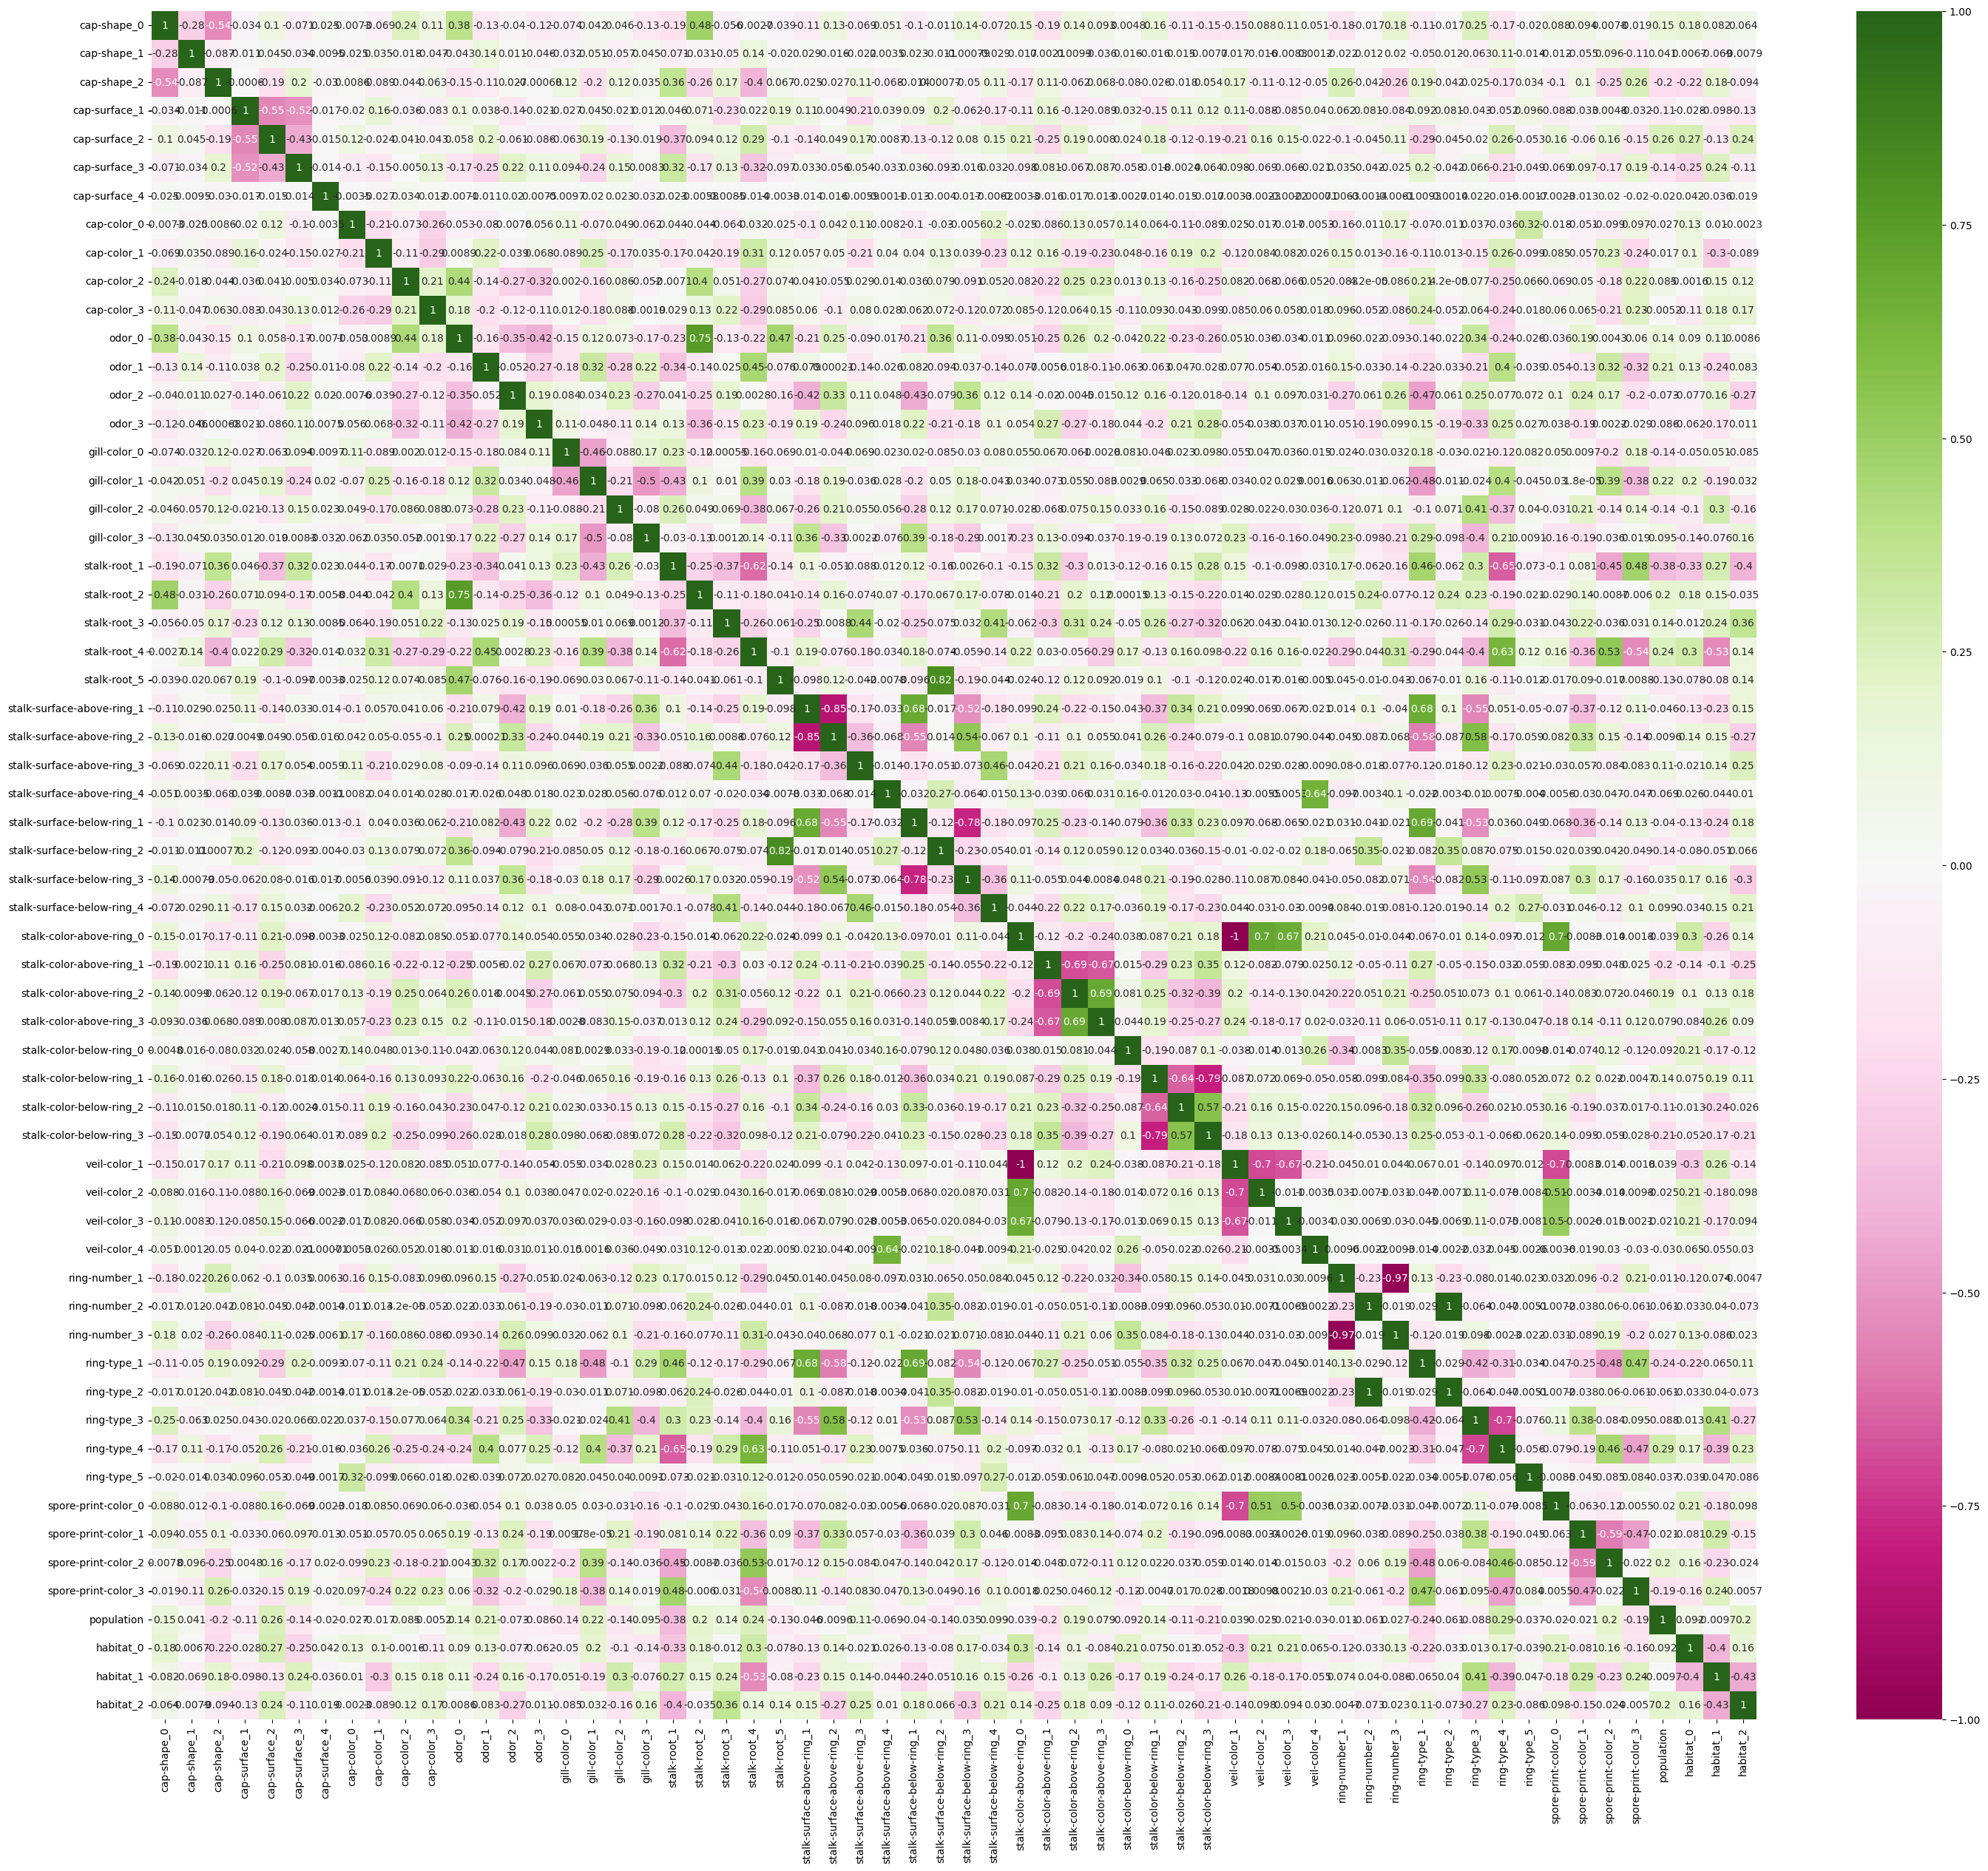

In [221]:
# correlation matrix
plt.figure(figsize=(35,30))
sns.heatmap(train_samples.corr(method="pearson"), annot=True, cmap='PiYG')
plt.show()

With how our matrix is set up, features that end up forming brightly-colored boxes and/or lines will represent those that are related: for instance, we can see that certain ring types are strongly related to certain stalk roots, which tells us that those features in combination may be significant. Other examples exist as well, like veil color and spore print color, or the stalk surface being above the ring and the ring type. Keeping this in mind, we can go through each set of related features and cross them together, providing us with aggregated features that, while not selected through expert domain knowledge, still represent a mathematically-supported linear relationship with each other.

In [222]:
cross_columns = [['veil-color_1', 'veil-color_2',
                  'veil-color_3', 'veil-color_4', 'spore-print-color_0',
                  'spore-print-color_1', 'spore-print-color_2', 'spore-print-color_3'],
                 ['stalk-surface-above-ring_1',
                  'stalk-surface-above-ring_2', 'stalk-surface-above-ring_3',
                  'stalk-surface-above-ring_4', 'ring-type_1', 'ring-type_2', 'ring-type_3',
                  'ring-type_4', 'ring-type_5'],
                 ['stalk-surface-below-ring_1',
                  'stalk-surface-below-ring_2', 'stalk-surface-below-ring_3',
                  'stalk-surface-below-ring_4', 'ring-type_1', 'ring-type_2', 'ring-type_3',
                  'ring-type_4', 'ring-type_5'],
                 ['stalk-root_1', 'stalk-root_2', 'stalk-root_3',
                  'stalk-root_4', 'stalk-root_5', 'ring-type_1', 'ring-type_2', 'ring-type_3',
                  'ring-type_4', 'ring-type_5'],
                 ['stalk-root_1', 'stalk-root_2', 'stalk-root_3',
                  'stalk-root_4', 'stalk-root_5', 'spore-print-color_0',
                  'spore-print-color_1', 'spore-print-color_2', 'spore-print-color_3']
]

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()

    # 1. create crossed labels by join operation
    X_crossed_train = train_samples[cols_list].apply(lambda x: '__'.join(str(x)), axis=1)
    X_crossed_test = test_samples[cols_list].apply(lambda x: '__'.join(str(x)), axis=1)

    # get a nice name for this new crossed column
    cross_col_name = '__'.join(cols_list)

    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))

    # 3. Save into dataframe with new name
    train_samples[cross_col_name] = enc.transform(X_crossed_train)
    test_samples[cross_col_name] = enc.transform(X_crossed_test)

    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name)

print(cross_col_df_names)

['veil-color_1__veil-color_2__veil-color_3__veil-color_4__spore-print-color_0__spore-print-color_1__spore-print-color_2__spore-print-color_3', 'stalk-surface-above-ring_1__stalk-surface-above-ring_2__stalk-surface-above-ring_3__stalk-surface-above-ring_4__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5', 'stalk-surface-below-ring_1__stalk-surface-below-ring_2__stalk-surface-below-ring_3__stalk-surface-below-ring_4__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5', 'stalk-root_1__stalk-root_2__stalk-root_3__stalk-root_4__stalk-root_5__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5', 'stalk-root_1__stalk-root_2__stalk-root_3__stalk-root_4__stalk-root_5__spore-print-color_0__spore-print-color_1__spore-print-color_2__spore-print-color_3']


Now that we have a set of crossed features, let's check to see if we have any features that do not explain the classification target, which we can therefore remove to eliminate noise during the PCA.

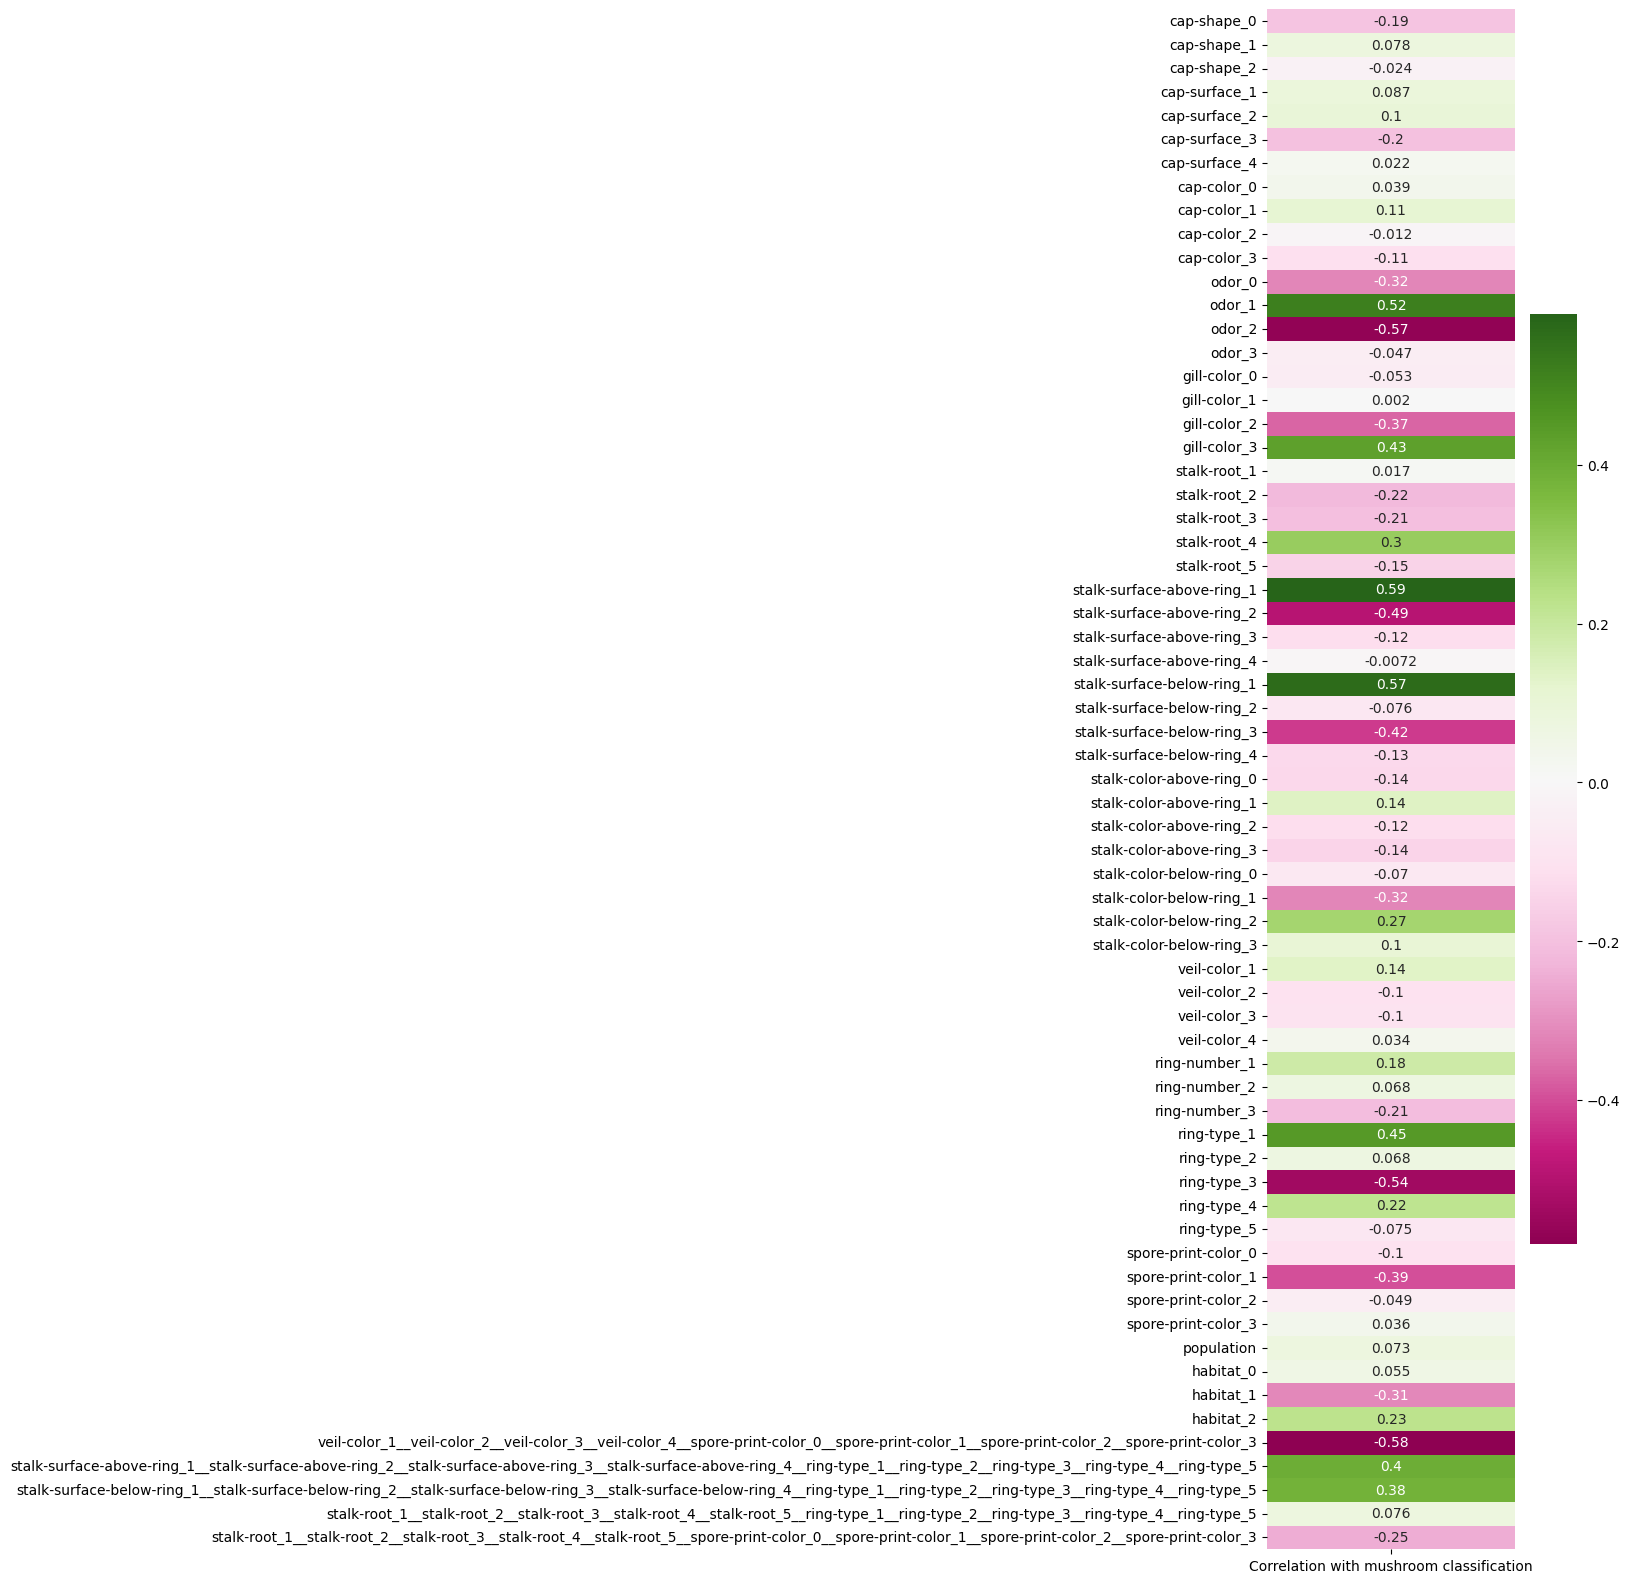

In [223]:
plt.figure(figsize=(4,20))
sns.heatmap(train_samples.corrwith(train_target, method="pearson").to_frame("Correlation with mushroom classification"), annot=True, cmap='PiYG')
plt.show()

It appears that our feature crossing was successful, with several of the new composite features providing a >|.5| correlation with our classification target! However, there are a number of features that are providing <|0.05| correlation, which can safely be removed to assist the PCA in finding relevant components.

In [224]:
train_samples.drop(columns=["cap-shape_2", "cap-surface_4", "cap-color_0", "cap-color_1", "odor_3", "gill-color_1", "stalk-surface-above-ring_4", "veil-color_4", "spore-print-color_0", "spore-print-color_3", "stalk-root_1"], axis=1, inplace=True)
test_samples.drop(columns=["cap-shape_2", "cap-surface_4", "cap-color_0", "cap-color_1", "odor_3", "gill-color_1", "stalk-surface-above-ring_4", "veil-color_4", "spore-print-color_0", "spore-print-color_3", "stalk-root_1"], axis=1, inplace=True)

Speaking of PCA, we need to ensure that we apply the appropriate form of PCA: most notably, we must understand if our data is linearly separable, or risk applying an irrelevant PCA kernel onto our data and ruining the hard work we have put into data preprocessing thus far.

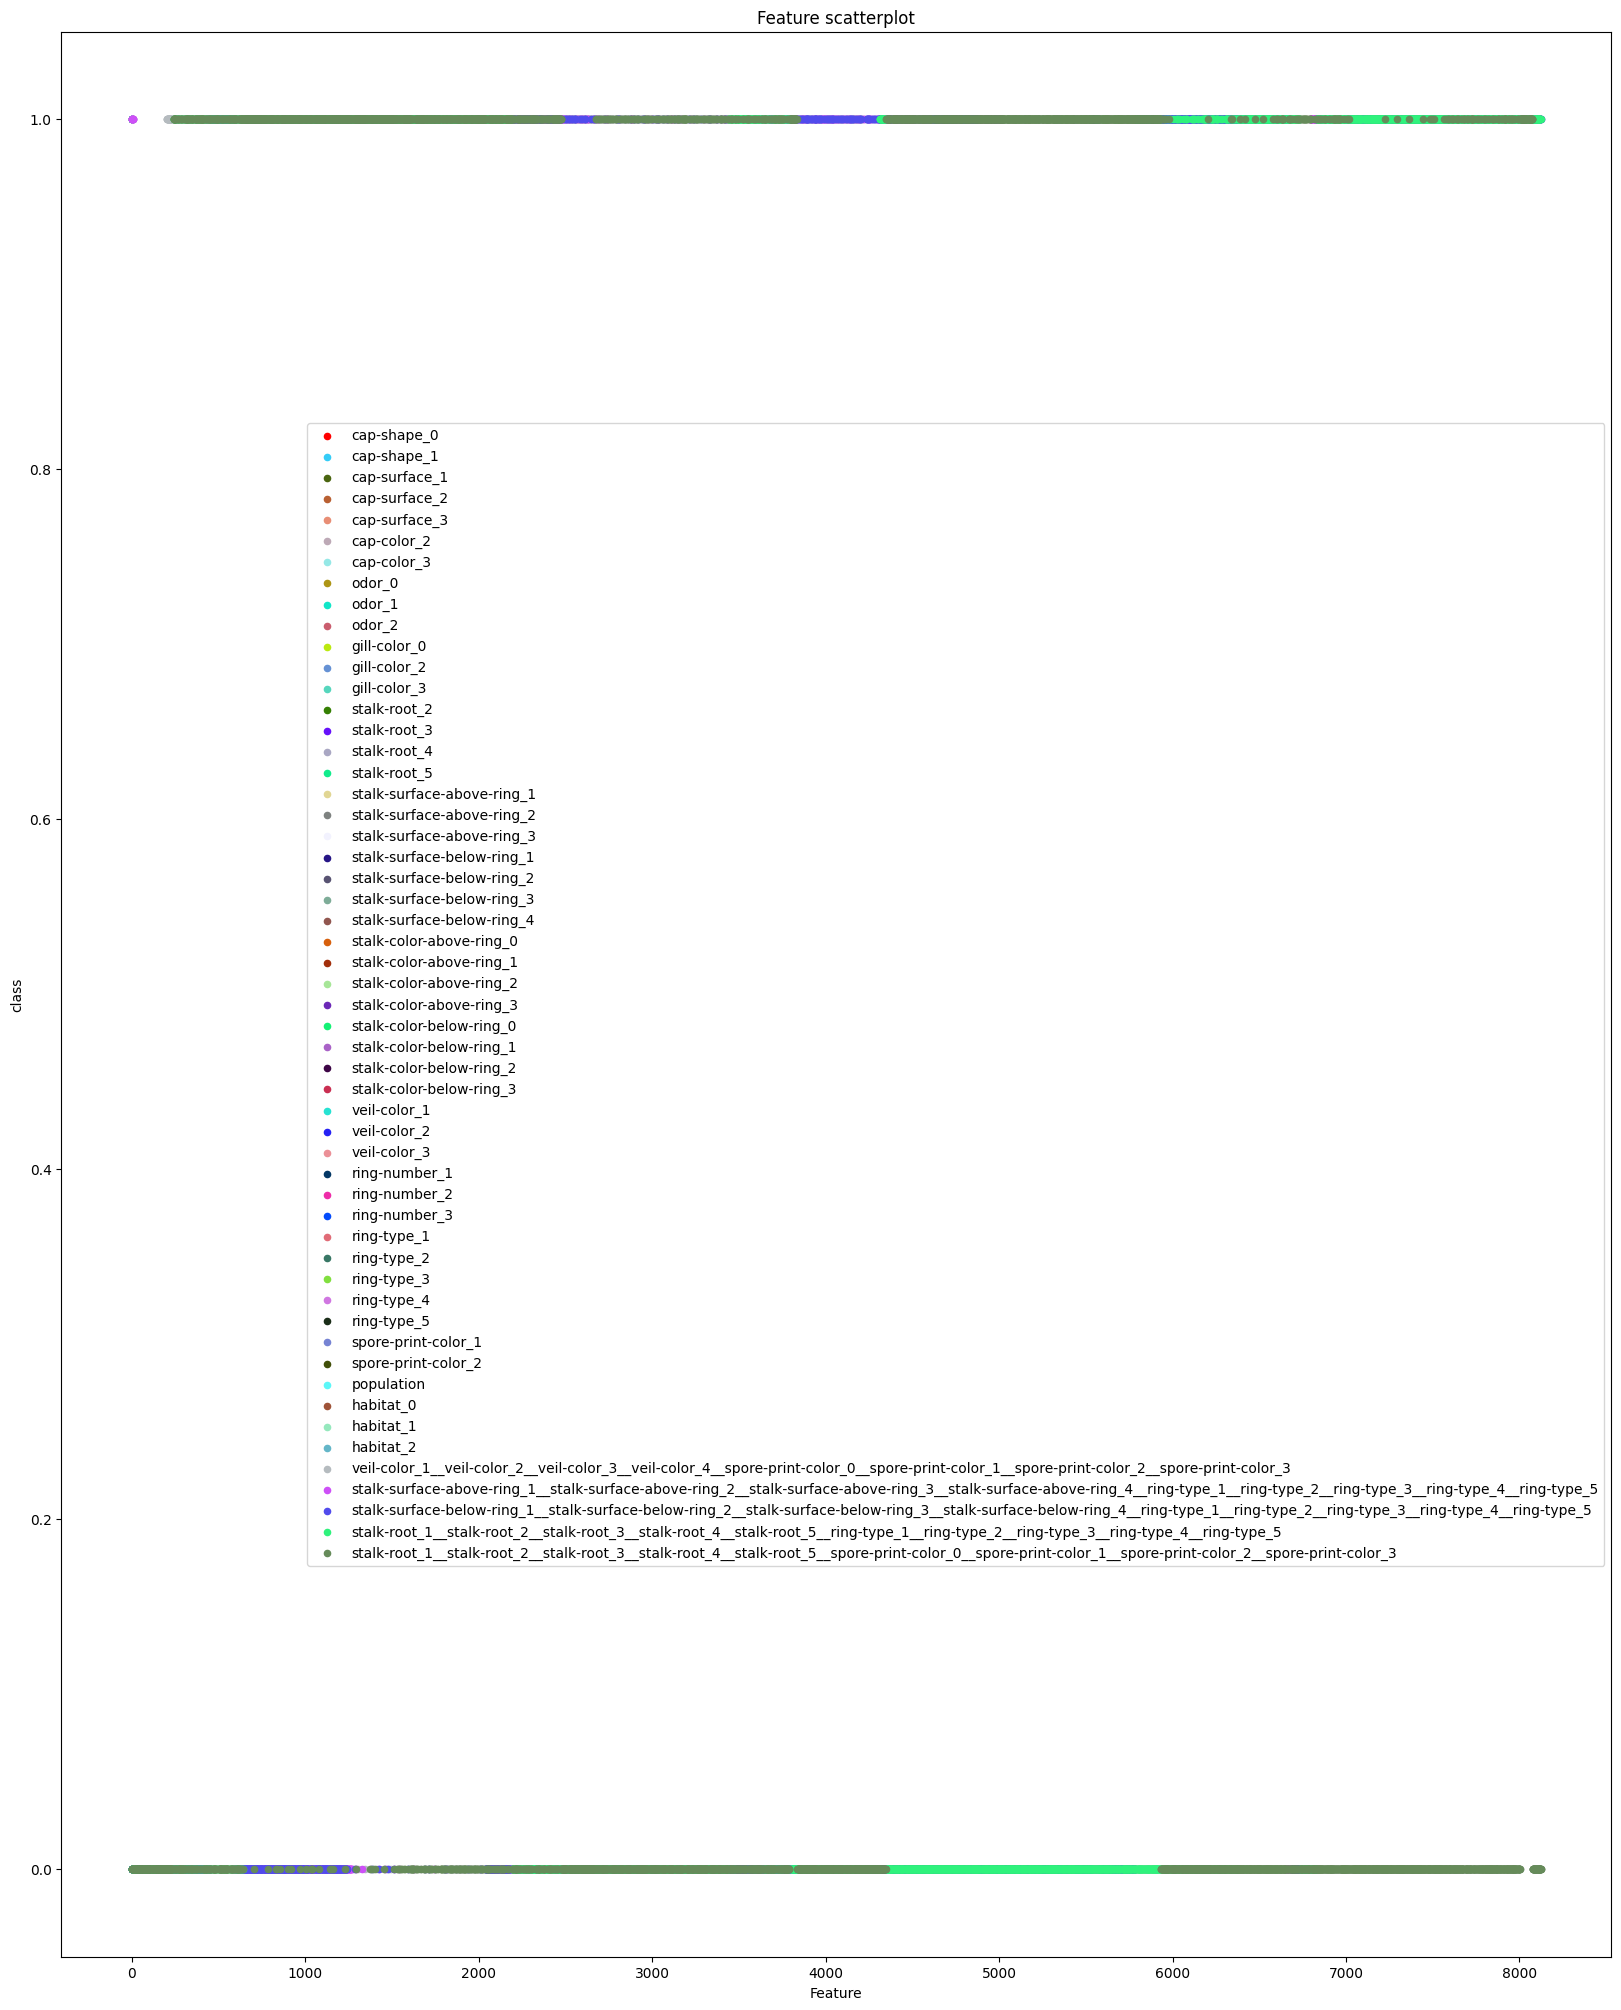

In [225]:
train_samples["class"] = train_target
axis = train_samples.plot.scatter(x="cap-shape_0", y="class", label="cap-shape_0", color="r", figsize=(20,25))

for column in train_samples.columns[1:]:
    if column == "class":
        continue
    color = (random.random(), random.random(), random.random())
    train_samples.plot.scatter(x=column, y="class", label=column, color=color, ax=axis)
axis.set_xlabel("Feature")
axis.set_title("Feature scatterplot")
plt.show()

train_samples.drop(columns=["class"], axis=1, inplace=True)

Based on the graph above, the data represents a relationship where each classification of data can be separated with a straight line, meaning a linear PCA-based decomposition should be able to accurately separate the data. With our data otherwise being preprocessed, we can now apply the PCA and evaluate whether it is able to detect meaningful components and successfully explain the variance of our dataset:

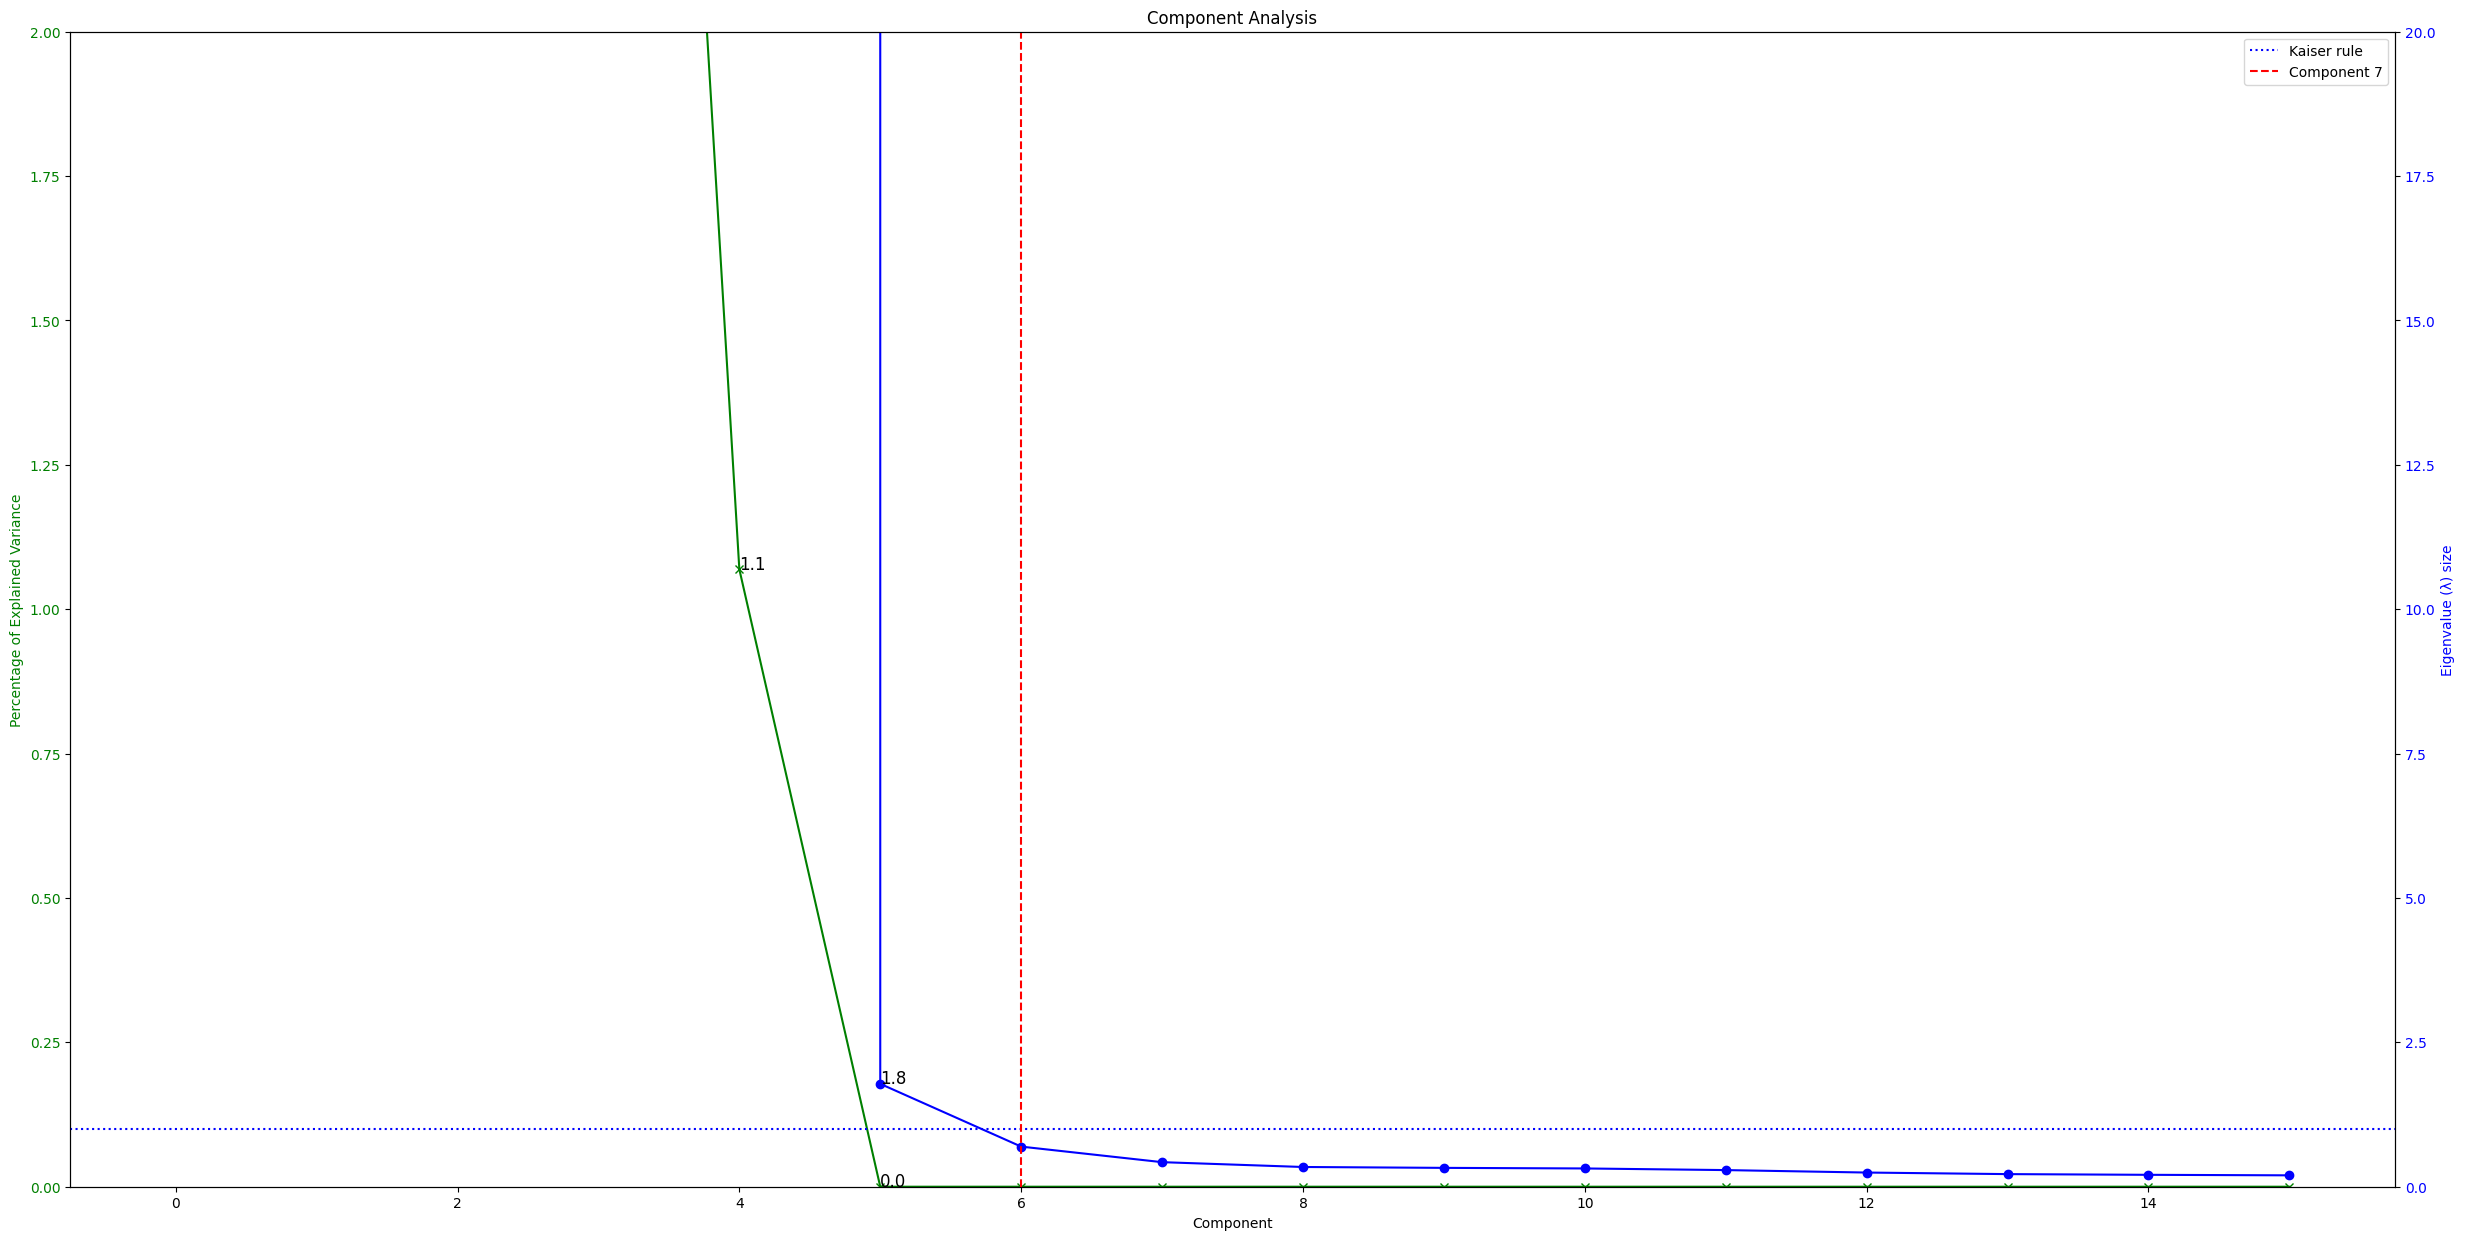

Amount of variance explained by 6 components s.t. λ_component > 1: 99.99999999999999%


In [226]:
# Linear PCA
pca = PCA(n_components=16, svd_solver="full")
pca_results = pca.fit_transform(train_samples)

color_var = "#008000"
color_eig = "#0000FF"
cutoff = 1
ylim = 2
fig, ax_var = plt.subplots(figsize=(30,15))
ax_eig = ax_var.twinx()
ax_var.set_xlabel("Component")
ax_var.set_title("Component Analysis")
ax_var.set_ylim(0, ylim)
ax_eig.set_ylim(0, ylim * 10)

ax_var.plot(pca.explained_variance_ratio_ * 100, marker="x", color=color_var)
ax_var.set_ylabel('Percentage of Explained Variance', color=color_var)
ax_var.tick_params(axis="y", labelcolor=color_var)

ax_eig.plot(pca.explained_variance_, marker="o", color=color_eig)
ax_eig.set_ylabel("Eigenvalue (λ) size", color=color_eig)
ax_eig.tick_params(axis="y", labelcolor=color_eig)
ax_eig.axhline(y=cutoff, linestyle=":", label="Kaiser rule", color=color_eig)

intersection = np.argwhere(np.diff(np.sign(cutoff - pca.explained_variance_))).flatten()
if len(intersection) == 0:
    num_components = len(pca.explained_variance_)
else:
    num_components = intersection[0] + 1
    ax_eig.axvline(x=num_components, linestyle="dashed", label="Component %d" %(num_components + 1), color="red")

linear_pca = PCA(n_components=num_components, svd_solver="full")
### Use these!
linear_pca_results_train = linear_pca.fit_transform(train_samples)
linear_pca_results_test = linear_pca.transform(test_samples)
### Use these!

_sum = 0
for index in range(num_components):
    if len(intersection) > 0:
        _sum = _sum + (pca.explained_variance_ratio_[index] * 100).round(1)
    if pca.explained_variance_ratio_[index] * 100 <= ylim:
        ax_var.text(index, pca.explained_variance_ratio_[index] * 100, (pca.explained_variance_ratio_[index] * 100).round(1), size=12)
    if pca.explained_variance_[index] <= ylim * 10:
        ax_eig.text(index, pca.explained_variance_[index], pca.explained_variance_[index].round(1), size=12)

ax_eig.legend(loc="upper right")
plt.show()
print("Amount of variance explained by " + str(num_components) + " components s.t. λ_component > 1: " + str(min(100, _sum)) + "%")

With all of our variance being able to be almost entirely explained in just a half-dozen components (as compared to our original 66 dimensions!), we can now move on to describing the final dataset which we shall be using, and then determine a metric we want to use to measure the overall performance of our models.

In [227]:
print(train_samples.columns)
train_samples.head()

Index(['cap-shape_0', 'cap-shape_1', 'cap-surface_1', 'cap-surface_2',
       'cap-surface_3', 'cap-color_2', 'cap-color_3', 'odor_0', 'odor_1',
       'odor_2', 'gill-color_0', 'gill-color_2', 'gill-color_3',
       'stalk-root_2', 'stalk-root_3', 'stalk-root_4', 'stalk-root_5',
       'stalk-surface-above-ring_1', 'stalk-surface-above-ring_2',
       'stalk-surface-above-ring_3', 'stalk-surface-below-ring_1',
       'stalk-surface-below-ring_2', 'stalk-surface-below-ring_3',
       'stalk-surface-below-ring_4', 'stalk-color-above-ring_0',
       'stalk-color-above-ring_1', 'stalk-color-above-ring_2',
       'stalk-color-above-ring_3', 'stalk-color-below-ring_0',
       'stalk-color-below-ring_1', 'stalk-color-below-ring_2',
       'stalk-color-below-ring_3', 'veil-color_1', 'veil-color_2',
       'veil-color_3', 'ring-number_1', 'ring-number_2', 'ring-number_3',
       'ring-type_1', 'ring-type_2', 'ring-type_3', 'ring-type_4',
       'ring-type_5', 'spore-print-color_1', 'spore-prin

,cap-shape_0,cap-shape_1,cap-surface_1,cap-surface_2,cap-surface_3,cap-color_2,cap-color_3,odor_0,odor_1,odor_2,...,spore-print-color_2,population,habitat_0,habitat_1,habitat_2,veil-color_1__veil-color_2__veil-color_3__veil-color_4__spore-print-color_0__spore-print-color_1__spore-print-color_2__spore-print-color_3,stalk-surface-above-ring_1__stalk-surface-above-ring_2__stalk-surface-above-ring_3__stalk-surface-above-ring_4__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5,stalk-surface-below-ring_1__stalk-surface-below-ring_2__stalk-surface-below-ring_3__stalk-surface-below-ring_4__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5,stalk-root_1__stalk-root_2__stalk-root_3__stalk-root_4__stalk-root_5__ring-type_1__ring-type_2__ring-type_3__ring-type_4__ring-type_5,stalk-root_1__stalk-root_2__stalk-root_3__stalk-root_4__stalk-root_5__spore-print-color_0__spore-print-color_1__spore-print-color_2__spore-print-color_3
4672,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,1,1020,7618,7618,7618,5161
7981,0,1,1,0,0,1,0,0,0,1,...,1,2,0,1,0,4117,6825,5817,4345,3833
2474,0,1,1,0,0,0,1,0,0,1,...,1,1,0,1,0,5025,3081,2999,4973,6318
532,0,1,1,0,0,1,1,0,1,0,...,0,3,0,1,1,7752,4798,4674,3697,3699
6167,0,0,0,1,0,0,0,0,1,0,...,1,4,0,0,1,2453,1360,5996,801,804


Concerning the dataset: the vast majority of the features, totalling 66, are simply existing features that have been split out via an appropriate encoding algorithm. For instance, cap shape, cap surface, and cap color already existed in the original dataset and have been split out into sets of either dummy or one-hot encoded features, depending on applicability. There are, however, several exceptions: the crossed features (noted by their long-winded column names) represent amalgamated features that showed a strong linear relationship with each other when viewed under a Pearson correlation study. While the team writing this paper does not have the relevant domain knowledge to ascribe formalized meaning to these relationships, we can confidently state that they represent a more complex relationship that evidences a property of mushrooms in general, much like how crossing most bird's coloration & size would end up being representative of their sex.
From this dataset, then, we build our final dataset: a set of 6 components created from a linear PCA that explain ~100% of the variance in the original dataset, but with only ~9% of the number of features/dimensions. While these components and their relationship to the original features is opaque and not directly interpretable (a problem with many DL/ML systems in general), we do have confidence through our eigenvalue analysis and application of the Kaiser rule that these components to accurately represent the original dataset and can be used to evaluate a model's performance in the classification of whether our mushroom is poisonous or edible.

But even with the dataset built, we must have a metric which we weigh the performance of a model on it with. Accuracy is a common, if often inappropriate measurement, and we believe we can improve upon using solely this metric. In our case, our dataset is exactly balanced, meaning that accuracy could be a useful metric for determining how often we predict the correct answer, however when considering the meaning of the dataset and what we are trying to classify (whether a mushroom is poisonous or edible), additional metrics can come in handy.
For example, a false negative for a mushroom being poisonous could have disastrous consequences for the person relying on the classification: with this in mind, recall/sensitivity would be an appropriate metric, as we want to minimize the false negative rate as much as possible. However, we still want to make sure that we are preforming well with respect to the true positive class, as a false positive could still have significant consequences in the case of a false edibility classification. For this reason, we can also utilize the precision metric, and take an aggregate performance measure of both of these (with our recall/sensitivity being somewhat more important that our precision) through an F1 score.
With all of these 4 metric combined, we should have a very strong foundation for determining the general performance and suitability of our models on our dataset.

# PLACEHOLDER BELOW

In [6]:
headers = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

df_train_orig = pd.read_csv('mushrooms.csv', names=headers)
df_test_orig = pd.read_csv('mushrooms.csv', names=headers)

df_test_orig = df_test_orig.iloc[1:]
print(df_train_orig.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8125 entries, ('class', 'cap-shape', 'cap-surface') to ('e', 'x', 's')
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8125 non-null   object
 1   cap-shape                 8125 non-null   object
 2   cap-surface               8125 non-null   object
 3   cap-color                 8125 non-null   object
 4   bruises                   8125 non-null   object
 5   odor                      8125 non-null   object
 6   gill-attachment           8125 non-null   object
 7   gill-spacing              8125 non-null   object
 8   gill-size                 8125 non-null   object
 9   gill-color                8125 non-null   object
 10  stalk-surface-below-ring  8125 non-null   object
 11  stalk-color-above-ring    8125 non-null   object
 12  stalk-color-below-ring    8125 non-null   object
 13  veil-type                 8125 

In [8]:

df_train = deepcopy(df_train_orig)
df_test = deepcopy(df_test_orig)

In [ ]:


# let's just get rid of rows with any missing data
# and then reset the indices of the dataframe so it corresponds to row number
df_train.replace(to_replace=' ?',value=np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.replace(to_replace=' ?',value=np.nan, inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index()

df_test.head()

In [ ]:


# replace weird strings inconsistency
if df_test.income.dtype=='object':
    df_test.income.replace(to_replace=[' <=50K.',' >50K.'],
                           value=['<=50K','>50K'],
                           inplace=True)
    print(df_test.income.value_counts())

# ========================================================
# define objects that can encode each variable as integer    
encoders = dict() # save each encoder in dictionary
categorical_headers = ['workclass','education','marital_status',
                       'occupation','relationship','race','sex','country']

# train all encoders (special case the target 'income')
for col in categorical_headers+['income']:
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()
    
    if col=="income":
        # special case the target, just replace the column
        tmp = LabelEncoder()
        df_train[col] = tmp.fit_transform(df_train[col])
        df_test[col] = tmp.transform(df_test[col])
    else:
        # integer encode strings that are features
        encoders[col] = LabelEncoder() # save the encoder
        df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
        df_test[col+'_int'] = encoders[col].transform(df_test[col])

# ========================================================
# scale the numeric, continuous variables
numeric_headers = ["age", "cap_gain", "cap_loss","work_hrs_weekly"]

ss = StandardScaler()
df_train[numeric_headers] = ss.fit_transform(df_train[numeric_headers].values)
df_test[numeric_headers] = ss.transform(df_test[numeric_headers].values)

# Code above does the same as the following, for each column:
# for col in numeric_headers:
#     df_train[col] = df_train[col].astype(np.float)
#     df_test[col] = df_test[col].astype(np.float)
    
#     ss = StandardScaler()
#     df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
#     df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))
    
df_test.head()

In [ ]:
# let's start as simply as possible, without any feature preprocessing
categorical_headers_ints = [x+'_int' for x in categorical_headers]

# we will forego one-hot encoding right now and instead just use all inputs as-is
#   this is just to get an example running in Keras (its not a good idea)
feature_columns = categorical_headers_ints+numeric_headers


pp = pprint.PrettyPrinter(indent=4)

print(f"We will use the following {len(feature_columns)} features:")
pp.pprint(feature_columns)

# combine the features into a single large matrix
X_train = df_train[feature_columns].to_numpy()
X_test = df_test[feature_columns].to_numpy()

y_train = df_train['income'].values.astype(np.int32)
y_test = df_test['income'].values.astype(np.int32)

In [ ]:
# we have the following lists now of data that we can use with our dataframes:
print("Numeric Headers:")
pp.pprint(numeric_headers) # normalized numeric data
print("\nCategorical String Headers:")
pp.pprint(categorical_headers) # string data
print("\nCategorical Headers, Encoded as Integer:")
pp.pprint(categorical_headers_ints) # string data encoded as an integer

In [ ]:
# Now let's define the architecture for a multi-layer network

# First, lets setup the input size
num_features = X_train.shape[1]
input_tensor = Input(shape=(num_features,))

# a layer instance is callable on a tensor, and returns a tensor
# Dense means a fully connected layer, with 10 hidden neurons and a bias term
x = Dense(units=10, activation='relu')(input_tensor)
x = Dense(units=5, activation='tanh')(x)
predictions = Dense(1, activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=input_tensor, outputs=predictions)

In [ ]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

In [ ]:


# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
%%time

model.fit(X_train, y_train, epochs=10, batch_size=50, verbose=1)

# now lets see how well the model performed

yhat_proba = model.predict(X_test) # sigmoid output probabilities
yhat = np.round(yhat_proba) # round to get binary class

print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

In [ ]:


# start by getting only the categorical variables
# these matrices are all integers
X_train = df_train[categorical_headers_ints].to_numpy() 
X_test = df_test[categorical_headers_ints].to_numpy() 

embed_branches = []
all_branch_outputs = [] # this is where we will keep track of output of each branch

# feed in the entire matrix of categircal variables
input_branch = Input(shape=(X_train.shape[1],), 
                     dtype='int64', 
                     name='categorical')

# for each categorical variable
for idx,col in enumerate(categorical_headers_ints):
    
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    # these lines of code do the same thing
    N = max(df_train[col].max(),df_test[col].max())+1
    N = len(encoders[categorical_headers[idx]].classes_)
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_branch, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs in list to concatenate later
    all_branch_outputs.append(x)
    
# now concatenate the outputs and add a fully connected layer
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=1,
                     activation='sigmoid', 
                     name='combined')(final_branch)

model = Model(inputs=input_branch, outputs=final_branch)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

In [ ]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
%%time

model.fit(X_train, y_train, epochs=10, batch_size=50, verbose=1)


yhat_proba = model.predict(X_test)
yhat = np.round(yhat_proba)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

In [ ]:
# save categorical features
X_train_cat = df_train[categorical_headers_ints].to_numpy() 
X_test_cat = df_test[categorical_headers_ints].to_numpy() 

# and save off the numeric features
X_train_num =  df_train[numeric_headers].to_numpy()
X_test_num = df_test[numeric_headers].to_numpy()

all_branch_outputs = [] # this is where we will keep track of output of each branch

# -----Like previous example, use embeddings from the integer data -----
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1
    N = len(encoders[categorical_headers[idx]].classes_)
    N_reduced = int(np.sqrt(N))
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_branch_outputs.append(x)
    
# -----HERE IS THE ADDING OF AN INPUT USING NUMERIC DATA-----
# create dense input branch for numeric
inputs_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=9, activation='relu', name='num_1')(inputs_num)
    
all_branch_outputs.append(x_dense)
# -------------------------------------------------------------------

# now concatenate the outputs and add a fully connected layer
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=10, activation='relu', name='combined_1')(final_branch)
final_branch = Dense(units=1, activation='sigmoid', name='combined_2')(final_branch)

model = Model(inputs=[input_cat,inputs_num], outputs=final_branch)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [ ]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
%%time

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit([ X_train_cat, X_train_num ], # inputs for each branch are a list
          y_train, 
          epochs=10, 
          batch_size=50, 
          verbose=1)

yhat = model.predict([X_test_cat,
                      X_test_num]) # each branch has an input

yhat = np.round(yhat)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

In [ ]:
# sandbox for looking at different categorical variables
for col in categorical_headers:
    vals = df_train[col].unique()
    print(col,'has', len(vals), 'unique values:')
    print(vals)

In [ ]:
# a quick example of crossing some columns

cols_list = ['marital_status','workclass','relationship']

# 1. create crossed labels by string join operation
X_crossed_train = df_train[cols_list].apply(lambda x: '_'.join(x), axis=1)
X_crossed_test = df_test[cols_list].apply(lambda x: '_'.join(x), axis=1)

# combine together for training
all_vals = np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy()))
print(np.unique(all_vals))
    
# 2. encode as integers, stacking all possibilities
enc = LabelEncoder()
enc.fit(all_vals)

encoded_vals_train = enc.transform(X_crossed_train)
encoded_vals_test  = enc.transform(X_crossed_test)

print(np.min(encoded_vals_train), np.max(encoded_vals_train))

In [ ]:
# now let's create some different crossed values
# possible crossing options:
#   'workclass','education','marital_status',
#   'occupation','relationship','race',
#   'sex','country'

# choose these as a class, what makes sense??
cross_columns = [#['race','sex','education','occupation'],
                 ['race','sex', 'marital_status','occupation'],
                 ['workclass','occupation'],
                 ['workclass','occupation','education'],
                 #['occupation','race','education'],
                 ['education','country']
                ]

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = df_train[cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
    
    # 3. Save into dataframe with new name
    df_train[cross_col_name] = enc.transform(X_crossed_train)
    df_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # Save the encoder used here for later:
    encoders[cross_col_name] = enc
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 
    
cross_col_df_names

In [ ]:
# Train a model only using crossed values
# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

crossed_outputs = [] # this is where we will keep track of output of each branch

input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='categorical')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1
    N = len(encoders[col].classes_)
    N_reduced = int(np.sqrt(N))
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='concat_1')
wide_branch = Dense(units=1,activation='sigmoid', name='combined')(wide_branch)

model = Model(inputs=input_crossed, outputs=wide_branch)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_train_crossed,
        y_train, epochs=10, batch_size=32, verbose=1)

In [ ]:
# bonus: we can keep training, picking up where we left of (no reinitialization)
model.fit(X_train_crossed,
        y_train, epochs=10, batch_size=32, verbose=1)

In [ ]:
yhat = np.round(model.predict(X_test_crossed))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

In [ ]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [ ]:
# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = df_train[categorical_headers_ints].to_numpy() 
X_test_cat = df_test[categorical_headers_ints].to_numpy() 

# and save off the numeric features
X_train_num =  df_train[numeric_headers].to_numpy()
X_test_num = df_test[numeric_headers].to_numpy()


# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1
    N = len(encoders[col].classes_)
    N_reduced = int(np.sqrt(N))
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1
    N_reduced = int(np.sqrt(N))
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=N_reduced, 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=20, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)



In [ ]:
# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)
# model.summary()

In [ ]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=15, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

In [ ]:
history = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=50, 
                    batch_size=32, 
                    verbose=0, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

In [ ]:
yhat = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

In [ ]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')